In [1]:
from scipy.constants import epsilon_0
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
from SimPEG.Utils import ndgrid
from ipywidgets import *

# Setup:

Sphere in a wholespace with a constant, uniform electric field

Parameters:

 - sigma_0 : conductivity of the background
 - sigma_1 : conductivity of the sphere

# Make a plot 

x = np.linspace(0,1,50)
m = 1
b = 10
y = m*x + b

fig,ax = plt.subplots(1,2,figsize=(4,5))
ax[0].plot(x,y)

ax[1].plot(y,x)
http://www.3ptscience.com/app/DCresistivity

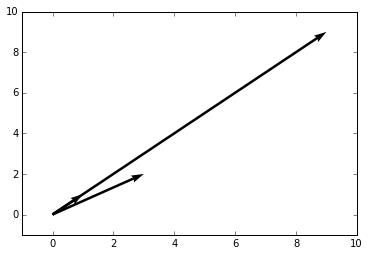

In [12]:
soa =np.array( [ [0,0,3,2], [0,0,1,1],[0,0,9,9]]) 
X,Y,U,V = zip(*soa)
plt.figure()
ax = plt.gca()
ax.quiver(X,Y,U,V,angles='xy',scale_units='xy',scale=1)
ax.set_xlim([-1,10])
ax.set_ylim([-1,10])
plt.draw()
plt.show()


(3, 4)


# Integer/Float

In [2]:
print 1/3
print 1./3.

0
0.333333333333


# Parameters for the sphere Problem


In [3]:
sig0 = 10        # conductivity of the wholespace
sig1 = 2           # conductivity of the sphere
R    = 50          # radius of the sphere
E0   = 1           # inducing field strength
xr = np.linspace(-2.*R, 2.*R, 100)
yr = xr.copy()
zr = np.r_[0] # identical to saying `zr = np.array([0])`
XYZ = ndgrid(xr,yr,zr) #Half-Space Definition
# d    = 2           # mesh spacing

In [4]:
r  = lambda x,y,z: np.sqrt(x**2+y**2+z**2)
sigf = lambda sig0,sig1: (sig1-sig0)/(sig1+2.*sig0)

In [5]:
# assumes an x-oriented inducing field
# and that the sphere is at the origin
def get_Potential(XYZ,sig0,sig1,R,E0): 
    
    x,y,z = XYZ[:,0],XYZ[:,1],XYZ[:,2]
    
    sig_cur= sigf(sig0,sig1)
    
    r_cur = r(x,y,z)
    
    ind0 = (r_cur > R)
    ind1 = (r_cur <= R)
    
    assert (ind0 + ind1).all(), 'Some indicies not included'
    
    V = np.zeros_like(x)
    
    V[ind0] = -E0*x[ind0]*(1.-sig_cur*R**3./r_cur[ind0]**3) # outside the sphere
    V[ind1] = -E0*x[ind1]*3.*sig0/(sig1+2.*sig0)
    
    return V

In [6]:
def get_Primary_Potential(XYZ,sig0,sig1,R,E0):
    x = XYZ[:,0]
    return - E0*x

In [7]:
#Define the conductivity for each point of the space
def get_Conductivity(XYZ,sig0,sig1,R):
    x,y,z = XYZ[:,0],XYZ[:,1],XYZ[:,2]
    r_view=r(x,y,z)
    
    int0= (r_view>R)
    int1= (r_view<=R)
    
    Sigma = np.zeros_like(x)
    
    Sigma[int0]=sig0
    Sigma[int1]=sig1
    
    return Sigma

<function __main__.plot_Potentials>

/Applications/Anaconda/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


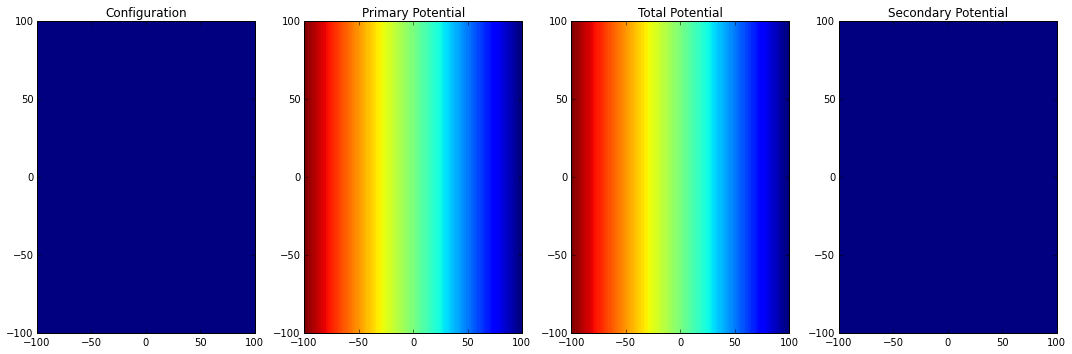

In [8]:
#Interactive tool to visualise the primary, secondary and total potentials

R_slider = FloatSlider(min=0., max =50., step=10.)
S_slider = FloatSlider(min=1., max =100., step=1.)

def plot_Potentials(R,sig1):
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    V = get_Potential(XYZ,sig0,sig1,R,E0)
    Vp = get_Primary_Potential(XYZ,sig0,sig1,R,E0)

    xcirc = xr[np.abs(xr) <= R]

    fig,ax = plt.subplots(1,4,figsize=(15,5))

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')

    ax[1].pcolor(xr,yr,Vp.reshape(xr.size,yr.size))
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_title('Primary Potential')

    ax[2].pcolor(xr,yr,V.reshape(xr.size,yr.size))
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[2].set_title('Total Potential')

    ax[3].pcolor(xr,yr,(V-Vp).reshape(xr.size,yr.size))
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[3].set_title('Secondary Potential')

    plt.tight_layout()
    
interact(plot_Potentials, R=R_slider, sig1=S_slider)

In [15]:
#Function that returns the primary and total electric fields

def get_ElectricField (XYZ,sig0,sig1,R,E0):
    
    x,y,z= XYZ[:,0], XYZ[:,1], XYZ[:,2]
    
    r_cur=r(x,y,z)
    
    int0= (r_cur>R)
    int1= (r_cur<=R)
        
    Ep = np.zeros(shape=(len(x),3))
    Ep[:,0] = E0
    
    Et = np.zeros(shape=(len(x),3))
    
    Et[int0,0] = E0 + E0*R**3./r_cur[int0]**5.*sigf(sig0,sig1)*(2.*x[int0]**2.-y[int0]**2.-z[int0]**2.);
    Et[int0,1] = E0*R**3./r_cur[int0]**5.*3.*x[int0]*y[int0]*sigf(sig0,sig1);
    Et[int0,2] = E0*R**3./r_cur[int0]**5.*3.*x[int0]*z[int0]*sigf(sig0,sig1);

    Et[int1,0] = 3.*sig0/(sig1+2.*sig0);
    Et[int1,1] = 0.;
    Et[int1,2] = 0.;
    
    return Et, Ep


In [ ]:
R_slider = FloatSlider(min=0., max =50., step=10.)
S_slider = FloatSlider(min=1., max =100., step=1.)

def plot_ElectricField(R,sig1):
   
    Sigma = get_Conductivity(XYZ,sig0,sig1,R)
    Et, Ep = get_ElectricField(XYZ,sig0,sig1,R,E0)
    
    xcirc = xr[np.abs(xr) <= R]
    
    fig,ax = plt.subplots(1,4,figsize=(15,5))

    ax[0].pcolor(xr,yr,Sigma.reshape(xr.size, yr.size))
    #ax[0].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[0].set_title('Configuration')

    ax[1].pcolor(xr,yr,Et[:,0].reshape(xr.size, yr.size))
    ax[1].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[1].set_title('Total Ex')

    ax[2].pcolor(xr,yr,Et[:,1].reshape(xr.size,yr.size))
    ax[2].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[2].set_title('Total Ey')

    ax[3].pcolor(xr,yr,(Et[:,0]-Ep[:,0]).reshape(xr.size,yr.size))
    ax[3].plot(xcirc,np.sqrt(R**2-xcirc**2),'--k',xcirc,-np.sqrt(R**2-xcirc**2),'--k')
    ax[3].set_title('Secondary Ex')

    plt.tight_layout()
    
interact(plot_ElectricField, R=R_slider, sig1=S_slider)

<function __main__.plot_ElectricField>